In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import urllib.request
import tarfile


In [3]:
def get_data(path ):
    tar_path = Path(path )
    path_list = str(tar_path).split('\\')
    if not tar_path.is_file():
        Path(path_list[:-1]).mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tar_path)
    with tarfile.open(tar_path) as tar:
        tar.extractall(Path('/'.join(path_list[:-1])))
    return pd.read_csv(Path('/'.join(path_list[:-1]) + '/housing/housing.csv'))

housing = get_data(r'E:\kecheng\mechinestu_notebook\机器学习总项目\ml-teach-main\datasets\housing.tgz')

In [4]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer,ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV ,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import  IsolationForest,RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sklearn

In [6]:
sklearn.set_config(display='diagram') # 所有估计器将呈现交互式图表，可以可视化流水线

In [7]:
# TODO:定义比例特征
def combined_feature_ratio(X):
    X = check_array(X, ensure_2d=True)
    return X[:,0:1] / X[:,1:2]

def combined_feature_ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy='mean'),
                         FunctionTransformer(combined_feature_ratio,feature_names_out=combined_feature_ratio_name),
                         StandardScaler(),
    )


In [8]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    # 超参数 集群中心数量n_clusters, 相似度gamma , 随机种子:random_state ：
    def __init__(self , n_clusters = 5 , gamma = 1.0 ,  random_state = None ):

        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self,X , y = None , sample_weight = None):
        X = check_array(X, ensure_2d=True)
        self.n_features_in_ = X.shape[1]
        try:
            self.feature_names_in_ = X.columns
        except AttributeError:
            self.feature_names_in_ = None
        self.kmeans_ = KMeans( n_clusters= self.n_clusters ,n_init= 10 , random_state=self.random_state)
        # KMeans.fit有sample_weight
        self.kmeans_.fit(X , sample_weight = sample_weight)
        return self

    def transform(self, X , ):
        # TODO:1. 检查是不是已经fit过 2. 检查输入的x是不是array  3. 检查特征数与训练是的特征数是否一致  4. 返回的是每个经纬度的点距离各个集群中心的相似度
        # 1.
        check_is_fitted(self)
        # 2.
        X = check_array(X)
        # 3.
        assert self.n_features_in_ == X.shape[1]
        # 4.
        return rbf_kernel(X , self.kmeans_.cluster_centers_ , gamma = self.gamma)

    def get_feature_names_out(self , names = None):
        if names is None:
            return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
        else:
            return [f"{names}_{i}" for i in range(self.n_clusters)]


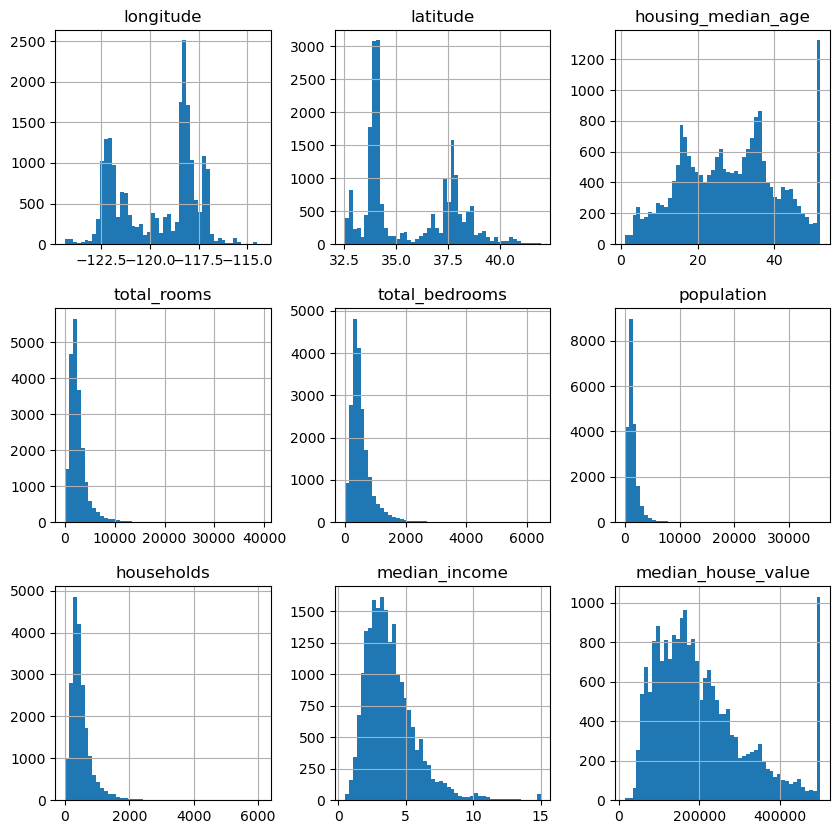

In [9]:
housing.hist(bins = 50 , figsize = (10,10))
plt.show()

In [10]:
# 对于普通数字特征列的流水线
num_pipeline = make_pipeline(SimpleImputer(strategy = 'median'), StandardScaler(),)
# 对于目录列的流水线
cat_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent'), OneHotEncoder(handle_unknown='ignore'))
# 对于重尾列的处理
log_pipeline = make_pipeline(SimpleImputer(strategy = 'median'),
                             FunctionTransformer(np.log,feature_names_out='one-to-one'),
                             StandardScaler(),)
# 经纬度的集群处理
clu1_preprocessing_pipeline = Pipeline([('clu',ClusterSimilarity(n_clusters = 10 , gamma = 1.0 , random_state = 42 ))])
housing.columns
# Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
#        'total_bedrooms', 'population', 'households', 'median_income',
#        'median_house_value', 'ocean_proximity'],
#       dtype='object')

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [11]:

# housing['median_income'].hist(bins = 10 , figsize = (5,5))
# plt.show()
# housing['income_cat'] = pd.cut(housing['median_income'] , bins = [0,1.5,3.0,4.5,6.0,np.inf],labels = [1,2,3,4,5])
# train_set,test_set = train_test_split(housing, test_size=0.2, random_state=42 , )


In [12]:
# todo: 异常值筛选并去除
# 经纬度没有缺失值策略，而标签在回归模型中必须所以要在其中排除掉三者有缺失值的样本
# housing = housing.loc[~pd.isnull(housing[['longitude' , 'latitude' , 'median_house_value' ]]).any( axis =1)]
X = housing.select_dtypes(include=[np.number])
X = num_pipeline.fit_transform(X)

iso_check = IsolationForest(random_state=42)
wrong_data  = iso_check.fit_predict(X)
# wrong_data
housing_without_iso = housing[wrong_data==1].copy()
# housing_without_iso[housing_without_iso.isnull().any(axis = 1)]


In [13]:
# TODO: 进行数据分化将数据分化成训练集和测试集
# 1. 增加income_cat列，为后续的分层采样做准备
housing_without_iso['income_cat'] =  pd.cut(housing_without_iso['median_income'] , bins = [0,1.5,3.0,4.5,6.0,np.inf],labels = [1,2,3,4,5])
housing_without_iso
train_set_stract,test_set_stract = train_test_split(housing_without_iso, test_size=0.2, random_state=42 , stratify=housing_without_iso['income_cat'])
# todo:清除不需要的属性，并将数据中的标签提取出来
X_train = train_set_stract.drop(['income_cat','median_house_value'] , axis=1)
y_train = train_set_stract['median_house_value']
X_test = test_set_stract.drop(['income_cat','median_house_value'] , axis=1)
y_test = test_set_stract['median_house_value']

In [14]:
# Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
#        'total_bedrooms', 'population', 'households', 'median_income',
#        'median_house_value', 'ocean_proximity'],
#       dtype='object')
processing = ColumnTransformer([
    ('ratio_bedrooms_ratio', ratio_pipeline(), ['total_bedrooms','total_rooms']),
    ('rooms_per_house' , ratio_pipeline(), ['total_rooms','households']),
    ('people_per_house'  , ratio_pipeline(), ['population' ,'households']),
    ('log',log_pipeline , ['total_rooms','total_bedrooms','population','households','median_income']),
    ("geo",clu1_preprocessing_pipeline, ["latitude", "longitude"]),
    ('cat' , cat_pipeline, make_column_selector(dtype_include=object)),
    ],remainder = num_pipeline,
)

In [15]:
full_pipeline = Pipeline(
    [
        ('preprocessing' , processing),
        ('svr',SVR())
    ])

In [17]:
grid_svr = [
    {
        "preprocessing__geo__clu__n_clusters": [5, 8, 10],
        "svr__C" : [0.1,0.3,1],
        "svr__epsilon" : [0.1,0.3,1],
        "svr__kernel" : ["linear"],
    },
    {
        "preprocessing__geo__clu__n_clusters": [5, 8, 10],
        "svr__C" : [0.1,0.3,1],
        "svr__epsilon" : [0.1,0.3,1],
        "svr__gamma" : [0.1,0.3,1],
        "svr__kernel" : ["rbf"],
    }
]
grid_search = GridSearchCV(full_pipeline, grid_svr, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train[:3000], y_train[:3000])



GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('ratio_bedrooms_ratio',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<functi...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000222A8A140A0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'preprocessing__geo__clu__n_clusters': [5, 8, 10],
                          'svr__C': [0.1, 0.3, 1],
                          'svr__epsilon': [0.1, 0.3, 1],
                          'svr__kernel': ['linear']},
                         {'preprocessing__geo__clu__n_clusters': [5, 8, 10],
                          'svr__C': [0.1, 0.3, 1],
                          'svr__epsilon': [0.1, 0.3, 1],
                          'svr__gamma': [0.1, 0.3, 1],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [18]:
grid_search.best_params_

{'preprocessing__geo__clu__n_clusters': 10,
 'svr__C': 1,
 'svr__epsilon': 0.1,
 'svr__kernel': 'linear'}

In [19]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('ratio_bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function combined_feature_ratio_nam...
                                                  Pipeline(steps=[('clu',
                                                                   ClusterSimilarity(n_clusters=10,
                                                                                     random_state=42))]),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000222A87FC460>)])),
                ('svr', SVR(C=1, kernel='linear'))])

In [20]:
from scipy.stats import randint,uniform
rand_svr = [
    {
        'preprocessing__geo__clu__n_clusters': randint(low=3, high=50),
        'svr__C': randint(low=1, high=20),
        "svr__epsilon": uniform(loc=0.1, scale=1.9),
        "svr__kernel": ["linear"],
    },
    {
        'preprocessing__geo__clu__n_clusters': randint(low=3, high=50),
        'svr__C': randint(low=1, high=20),
        "svr__epsilon": uniform(loc=0.1, scale=2.9),
        "svr__gamma": uniform(loc=0.1, scale=1.9),
        "svr__kernel": ["linear"],
    }
]
rand_search = RandomizedSearchCV(full_pipeline, rand_svr, cv=3,n_iter=10,scoring='neg_root_mean_squared_error', random_state=42)


In [21]:
rand_search.fit(X_train[:3000], y_train[:3000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('ratio_bedrooms_ratio',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<...
                                         'svr__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000222A87DBA90>,
                                         'svr__epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000222A87DAF20>,
                                         'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000222A87DB130>,
                                         'svr__kernel': ['linear']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [22]:
rand_search.best_params_


{'preprocessing__geo__clu__n_clusters': 49,
 'svr__C': 19,
 'svr__epsilon': 1.209139774674772,
 'svr__gamma': 1.9681386830328975,
 'svr__kernel': 'linear'}

In [23]:
rand_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('ratio_bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function combined_feature_ratio_nam...
                                                                                     random_state=42))]),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000222A8805ED0>)])),
                ('svr',
                 SVR(C=19, epsilon=1.209139774674772, gamma=1.9681386830328975,
                     kernel='linear'))])

In [24]:
processing_selected = Pipeline([('preprocessing' , processing),
                                ('select_',SelectFromModel(estimator=LinearRegression(),threshold='median')),
                                ("reg_",LinearRegression())])


In [25]:
select_linear= processing_selected.fit(X_train, y_train)

In [26]:
select_linear_pred = select_linear.predict(X_test)

linear_rmse = mean_squared_error(y_test, select_linear_pred, squared=False)
print(linear_rmse)

66715.60300495183


In [27]:
processing_selected = Pipeline([('preprocessing' , processing),
                                ('select_',SelectFromModel(estimator=LinearRegression(),threshold='median')),
                                ("reg_",DecisionTreeRegressor())])
select_DT= processing_selected.fit(X_train, y_train)

In [28]:
select_DT_pred = select_DT.predict(X_test)

DT_rmse = mean_squared_error(y_test, select_DT_pred, squared=False)
print(DT_rmse)

67599.36122622034


In [30]:
processing_selected = Pipeline([('preprocessing' , processing),
                                ('select_',SelectFromModel(estimator=LinearRegression(),threshold='median')),
                                ("reg_",RandomForestRegressor(random_state=42))])
forest_rmses = -cross_val_score(processing_selected, X_train, y_train,
                                scoring="neg_root_mean_squared_error", cv=10)


In [34]:
select_RF = processing_selected.fit(X_train, y_train)
select_RF_pred = select_RF.predict(X_test)

RF_rmse = mean_squared_error(y_test, select_RF_pred, squared=False)
print(RF_rmse)

50240.16671795905


In [38]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     51655.228533
std       2337.398418
min      46762.087286
25%      50705.998008
50%      51749.243240
75%      53159.448745
max      54627.861669
dtype: float64

In [66]:
from sklearn.neighbors import KNeighborsRegressor
class KNeighors(BaseEstimator,TransformerMixin):
    def __init__(self, n_neighbors = 5):
        self.n_neighbors = n_neighbors
    def fit(self, X, y):
        X = check_array(X,ensure_2d=True)
        self.knn_ = KNeighborsRegressor(n_neighbors=self.n_neighbors)
        self.knn_.fit(X, y)
        return self
    def transform(self, X):
        X = check_array(X,ensure_2d=True)
        return self.knn_.predict(X).reshape(-1, 1)
    def predict(self, X):
        X = check_array(X,ensure_2d=True)
        return self.knn_.predict(X).reshape(-1, 1)



In [67]:
clu2_preprocessing_pipeline = Pipeline([('clu2',KNeighors( n_neighbors= 10 ))])
processing = ColumnTransformer([
    ('ratio_bedrooms_ratio', ratio_pipeline(), ['total_bedrooms','total_rooms']),
    ('rooms_per_house' , ratio_pipeline(), ['total_rooms','households']),
    ('people_per_house'  , ratio_pipeline(), ['population' ,'households']),
    ('log',log_pipeline , ['total_rooms','total_bedrooms','population','households','median_income']),
    ("geo2",clu2_preprocessing_pipeline, ["latitude", "longitude"]),
    ('geo1',clu1_preprocessing_pipeline, ["latitude", "longitude"]),
    ('cat' , cat_pipeline, make_column_selector(dtype_include=object)),
    ],remainder = num_pipeline,
)



In [68]:
grid_canshu = [
    {
        "preprocessing__geo1__clu__n_clusters": [5, 8, 10],
        "preprocessing__geo2__clu2__n_neighbors" : [8,10,15],
    }]

full_pipeline1 = Pipeline([
    ("preprocessing" , processing),
    ("reg",LinearRegression())
])
grid_search_linear = GridSearchCV(full_pipeline1, grid_canshu, cv=3,scoring='neg_root_mean_squared_error')
grid_search_linear.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('ratio_bedrooms_ratio',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<functi...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000222AE1BB670>)])),
                                       ('reg', LinearRegression())]),
             param_grid=[{'preprocessing__geo1__clu__n_clusters': [5, 8, 10],
                          'preprocessing__geo2__clu2__n_neighbors': [8, 10,
                                                                     15]}],
             scoring='neg_root_mean_squared_error')

In [50]:
grid_search_linear.best_params_

{'preprocessing__geo1__clu__n_clusters': 10,
 'preprocessing__geo2__clu2__n_neighbors': 8}

In [51]:
grid_search_linear.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('ratio_bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function combined_feature_ratio_nam...
                                                  Pipeline(steps=[('clu',
                                                                   ClusterSimilarity(n_clusters=10,
                                                                                     random_state=42))]),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000222BCED04F0>)])),
                ('reg', LinearRegression())])

In [53]:
rand_canshu = [
    {
        "preprocessing__geo1__clu__n_clusters": randint(low=3, high=50),
        "preprocessing__geo2__clu2__n_neighbors" : randint(low=3, high=50),
    }]
full_pipeline2 = Pipeline([
    ("preprocessing" , processing),
    ("reg",DecisionTreeRegressor())
])
rand_search_DT = RandomizedSearchCV(full_pipeline2, rand_canshu, cv=3,scoring='neg_root_mean_squared_error')
rand_search_DT.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('ratio_bedrooms_ratio',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x00000222BCED20E0>)])),
                                             ('reg', DecisionTreeRegressor())]),
                   param_distributions=[{'preprocessing__geo1__clu__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000222BCED0250>,
                                         'preprocessing__geo2__clu2__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000222BCE2BBB0>}],
                   scoring='neg_root_mean_squared_error')

In [54]:
rand_search_DT.best_params_

{'preprocessing__geo1__clu__n_clusters': 13,
 'preprocessing__geo2__clu2__n_neighbors': 4}

In [55]:
rand_search_DT.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('ratio_bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function combined_feature_ratio_nam...
                                                  Pipeline(steps=[('clu',
                                                                   ClusterSimilarity(n_clusters=13,
                                                                                     random_state=42))]),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000222BCEF8730>)])),
                ('reg', DecisionTreeRegressor())])

4. 从头开始再次实现StandardScalerClone类（对数据做标准化），然后添加对inverse_transform()方法的支持：执行scaler.inverse_transform(scaler.fit_transform(X))应该返回一个非常接近X的数组。
       然后添加对特征名称的支持：如果输入是DataFrame，则在fit()方法中设置feature_names_in_。该属性类型是NumPy数组，存列的名字。
       最后，实现get_feature_names_out()方法：这个方法应该有一个可选的input_features=None参数。如果传了这个参数，这个方法应检查其长度是否匹配n_features_in_，如果有feature_names_in_属性，则应匹配feature_names_in_的长度，然后应返回input_features。
       如果input_features为None，则该方法应返回feature_names_in_（如果有这个属性）​，否则返回长度为n_features_in_的   np.array(["x0"，"x1"，"x2", ...])。

In [84]:
class StandardScalerClone(BaseEstimator,TransformerMixin):
    def __init__(self,with_mean=True):
        self.with_mean = with_mean

    def fit(self,X,y=None):
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        try:
            self.feature_names_in_ = X.columns.toarray().flatten()
        except AttributeError:
            self.feature_names_in_=np.array( [f'x{i}' for i in range(self.n_features_in_) ])

        return self
    def transform(self,X , y=None):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.std_
    def inverse_transform(self,scaled_X):
        check_is_fitted(self)
        scaled_X = check_array(scaled_X)
        assert self.n_features_in_ == scaled_X.shape[1]
        return scaled_X * self.std_ + self.mean_
    def get_feature_names_out(self , input_features=None):
        if  input_features is not None:
            assert len(input_features) == self.n_features_in_ ,"特征数量不匹配"
            return input_features
        else:
            return self.feature_names_in_


In [85]:
X = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])
X

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [86]:
ssc = StandardScalerClone()
ssc.fit(X)

StandardScalerClone()

In [87]:
ssc.fit_transform(X)

array([[-1.22474487, -1.22474487, -1.22474487],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.22474487,  1.22474487,  1.22474487]])

In [88]:
ssc.inverse_transform(ssc.fit_transform(X))

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [89]:
ssc.get_feature_names_out()

array(['x0', 'x1', 'x2'], dtype='<U2')

In [90]:
ssc.get_feature_names_out(input_features=np.array(['x_a','x_b']))


AssertionError: 特征数量不匹配

In [91]:
ssc.get_feature_names_out(input_features=np.array(['x_a','x_b','x_c']))

array(['x_a', 'x_b', 'x_c'], dtype='<U3')